### Alpha model

We consider the performance of our alpha model (`value + momentum`) across our history, with the predictive ranking performance. We evaluate return performance separately for our two strategies (alpha extension and equity market neutral).

We take a ridge regression approach due to the collinearity that exists between some of our factors.

In [1]:
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os
from cycler import cycler

plt.style.use("dark_background")

load_dotenv('../.env')

db_url = os.getenv('DB_URL')
psql = create_engine(db_url)

In [2]:
alpha_factors = pd.read_sql(
    """
    select * from factor_scores
    """,
    psql
)

# monthly pricing data
price_data = pd.read_sql(
    """
    select * from eom_prices
    """,
    psql
)

# get required returns data
price_data = price_data.sort_values(['ticker', 'date'])
price_data['return'] = price_data.groupby('ticker')['price'].transform(lambda x: x.pct_change())
price_data['t_plus_3_return'] = price_data.groupby('ticker')['price'].transform(lambda x: x.shift(-3) / x - 1)

# constituent data for our russell 1000 proxy
monthly_constituents = pd.read_sql(
    """
    select * from monthly_constituents
    """,
    psql
)

In [4]:
# change to a wide format
wide_alpha = alpha_factors.pivot_table(
    index = ['date', 'ticker'],
    columns = 'factor',
    values = 'score'
).reset_index()

alpha_data = price_data.merge(wide_alpha, how='left', on=['date', 'ticker']).dropna()
alpha_data = alpha_data.merge(monthly_constituents, how='left', on=['date', 'ticker']).dropna()
alpha_data['date'] = pd.to_datetime(alpha_data['date'])
alpha_data = alpha_data.dropna()

In [76]:
from sklearn.linear_model import Ridge
from scipy.stats.mstats import winsorize

# our factors
factors = ['EVEBIT', 'EVEBITDA', 'MOMENTUM', 'PB', 'PE', 'PS']
alpha_data = alpha_data.sort_values('date')

dates = alpha_data['date'].unique()
lookback = 3

alpha_model_ic = []
model_stats = []

for i in range(lookback + 4, len(dates)):
    # i - 4, as we take 3-month lookahead returns to train
    tst_end = i - 4
    tst_start = tst_end - lookback
    tst_data = alpha_data[
        (alpha_data['date'] >= dates[tst_start]) &
        (alpha_data['date'] <= dates[tst_end])
    ].copy()

    # get training for alpha model
    X_tr = tst_data[factors].apply(lambda col: winsorize(col, limits=[0.05, 0.05]))
    y_tr = winsorize(tst_data['t_plus_3_return'], limits=[0.01, 0.01])
    
    # get the alpha model
    alpha_model = Ridge(alpha=1.0)
    alpha_model.fit(X_tr, y_tr)

    # now get the current months data
    tst_data = alpha_data[alpha_data['date'] == dates[i]]
    X_tst = tst_data[factors].apply(lambda col: winsorize(col, limits=[0.05, 0.05]))
    
    X_tst['pred_return'] = alpha_model.predict(X_tst)
    
    alpha_model_ic.append({
        'date': dates[i],
        'rank_ic': X_tst['pred_return'].corr(tst_data['t_plus_3_return'], method='spearman')
    })

    model_stats.append({
        'tst_start': dates[tst_start],
        'tst_end': dates[tst_end],
        'pred_date': dates[i],
        'training_r_squared': alpha_model.score(X_tr, y_tr)
    })

    
model_stats_df = pd.DataFrame(model_stats)
alpha_model_ic_df = pd.DataFrame(alpha_model_ic)
alpha_model_ic_df['rolling_rank_ic'] = alpha_model_ic_df['rank_ic'].rolling(window=60).mean()
alpha_model_ic_df = alpha_model_ic_df.dropna()

Text(0, 0.5, 'Cross-sectional rank IC (Rolling 5-year mean)')

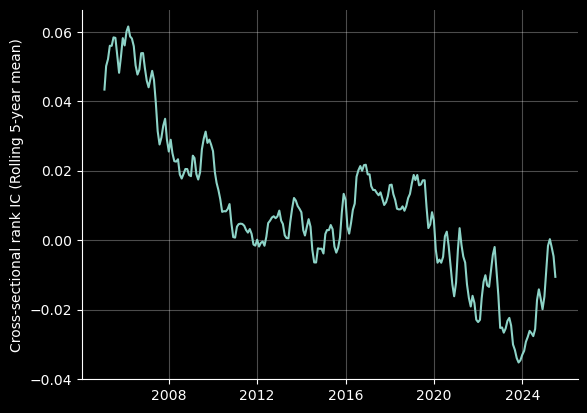

In [77]:
plt.plot(alpha_model_ic_df['date'], alpha_model_ic_df['rolling_rank_ic'])
plt.grid(alpha=0.3)
sns.despine()
plt.ylabel('Cross-sectional rank IC (Rolling 5-year mean)')

We can see that our alpha model post 2020 quickly decays, beginning to recover post 2024. Consider the training model's rank IC across history.

Text(0, 0.5, 'In-training $R^2$')

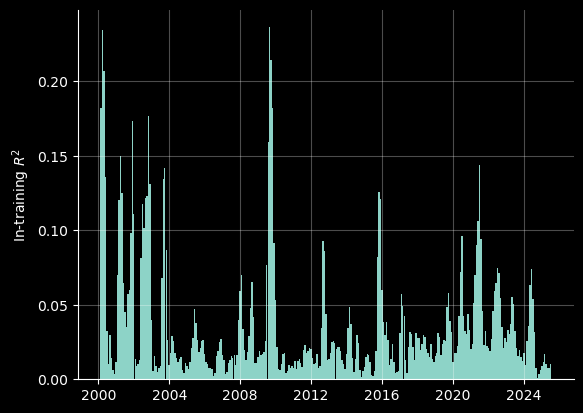

In [ ]:
plt.bar(model_stats_df['pred_date'], model_stats_df['training_r_squared'], width=30)
sns.despine()
plt.grid(alpha=0.3)
plt.ylabel('Training $R^2$')

We can see in the above $R^2$ time series when the model has low and high in-training explainability.  Overall, our alpha model has weak-to-moderate explainability of future 3-month returns.